In [1]:
import os
import json
import re
from tqdm import tqdm,tqdm_pandas
import pandas as pd
import numpy as np
from kiwipiepy import Kiwi
from datetime import datetime

import chart_studio.plotly.plotly as py
import cufflinks as cf
cf.go_offline(connected=True)

# Data load

In [2]:
def data_load(name):
    with open(f'crawl_result/{name}.json','r',encoding='utf-8')as f:
        data=json.load(f)
        DF=pd.DataFrame(data['data'])
    return DF

In [3]:
QA=data_load('wineQ&A_text')
rec=data_load('wine_recommend_text')

In [4]:
def clean_text(text):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    text=emoji_pattern.sub(r'', text)
    re_pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),|]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    text = re.sub(re_pattern, 'url', text)
    text = re.sub('\([^)]*\)', ',', text)
    text = re.sub('\[[^)]*\]', ',', text)
    text=re.sub('[^ㄱ-ㅎ ㅏ-ㅣ가-힣A-Za-z0-9!?]+',' ',text)
    text=re.sub('[\\s+ *]',' ',text)
    return text

In [5]:
def cleaning(DF):
    DF['clean_content']=DF.본문.apply(lambda x:clean_text(x))
    DF['clean_title']=DF.제목.apply(lambda x:clean_text(x))
    DF['contents']=DF.clean_title+DF.clean_content
    return DF

In [6]:
QA=cleaning(QA)
REC=cleaning(rec)

In [7]:
QA['date']=QA.날짜.apply(lambda x: datetime.strptime(''.join(x.split('.')[:3]),'%Y%m%d'))

In [8]:
Date_count=QA.groupby('date').count().loc[:,'본문']

In [9]:
Date_count.sort_values(ascending=False)[:10]

date
2020-12-24    35
2020-10-15    31
2021-01-03    30
2020-12-25    29
2020-12-23    29
2021-05-11    28
2021-05-12    28
2021-04-15    27
2020-10-17    27
2021-05-15    27
Name: 본문, dtype: int64

In [10]:
#Date_count.iplot(kind='bar',colors='Red')

In [11]:
Date_count.var()

45.2910899142265

# 띄어쓰기 교정


In [ ]:
#! pip install git+https://github.com/ssut/py-hanspell.git

In [ ]:
from hanspell import spell_checker
sent = QA.contents[3]
spelled_sent = spell_checker.check(sent)

hanspell_sent = spelled_sent.checked
print(hanspell_sent)

In [ ]:
tqdm.pandas()
QA['spell_check_contents']=QA.contents.progress_apply(lambda x: spell_checker.check(x).checked 
                                                      if spell_checker.check(x).checked !='' else x
                                                     )

In [ ]:
#QA.spell_check_contents[5]

In [ ]:
QA.to_csv('crawl_result/Q&Adata.csv')

In [ ]:
import matplotlib.font_manager as font_manager
font_list = font_manager.findSystemFonts(fontpaths=None, fontext='ttf')
# 처음 10개만 출력
font_list[:-10]

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

def show_contents_length(DF):
    font_name = font_manager.FontProperties(fname='/System/Library/Fonts/Supplemental/Arial Narrow Bold Italic.ttf'
                                           ).get_name()
    rc('font', family=font_name,size=15)
    plt.figure(figsize=(10, 8))
    print('컨텐츠의 최대 길이 :',max(len(l) for l in  DF.contents))
    print('컨텐츠의 평균 길이 :',sum(map(len, QA.contents))/len(DF.contents))
    plt.hist([len(s) for s in DF.contents], bins=50,color='#d62728')
    plt.xlabel('length of contents')
    plt.ylabel('number of contents')
    plt.show()

In [ ]:
show_contents_length(QA)

# Tokeninzing

In [12]:
from soynlp.utils import DoublespaceLineCorpus
from soynlp.word import WordExtractor
from soynlp.tokenizer import MaxScoreTokenizer
from gensim.models import Word2Vec
from soynlp.noun import LRNounExtractor_v2


def soytokenizer(DF):
    S=DF.contents
    corpus = DoublespaceLineCorpus(S, iter_sent=True)
    word_extractor = WordExtractor(min_frequency=2,
        min_cohesion_forward=0.5, 
        min_right_branching_entropy=0.0
    )
    word_extractor.train(S) # list of str or like
    words = word_extractor.extract()
    
#     noun_extractor = LRNounExtractor_v2(verbose=True)
#     noun_extractor.train(S) 
#     nouns = noun_extractor.train_extract(S)

    cohesion_score = {word:score.cohesion_forward for word, score in words.items() if 1.0 > score.cohesion_forward >=0.8}
    #score = {word:score.cohesion_forward for word, score in nouns.items() if 1.0 > int(score['score']) >=0.6}
    
    Wtokenizer = MaxScoreTokenizer(scores=cohesion_score)  
    #Ntokenizer = MaxScoreTokenizer(scores=score)
    return Wtokenizer

In [13]:
QA['more_clear']=QA.contents.apply(lambda x: re.sub('[^ㄱ-ㅎ ㅏ-ㅣ가-힣A-Za-z]+',' ',x))
WT=soytokenizer(QA)
QA['soytoken']=QA.contents.apply(lambda x: WT.tokenize(x))

training was done. used memory 0.385 Gbry 0.255 Gb
all cohesion probabilities was computed. # words = 59465
all branching entropies was computed # words = 39925
all accessor variety was computed # words = 39925


In [14]:
def Kiwi_nouns(DF):
    kiwi = Kiwi(num_workers=16)
    kiwi.prepare()
    a=[]
    Total=[]
    for result in kiwi.analyze(DF.contents, top_n=1):
        R=result[0]
        for i in range(len(R[0])):
            if R[0][i][1] in ['NNG','NNP']:
                a.append(R[0][i][0])
            if  R[0][i][1] in ['VV','VA']:
                a.append(R[0][i][0]+'다')
        Total.append(a)
        a=[]
    target_title = [[each_word for each_word in each_doc if each_word] for each_doc in Total]
    return target_title

In [15]:
docs=QA.contents
QA['kiwi_nouns']=Kiwi_nouns(QA)

In [70]:
def Get_unique_nouns(DF):
    New=[]
    Total=[]
    Stopwords=['클릭','소통','등급','감사','안녕','리딩','답변','댓글','엄청',
                '등급', '기본', '안내', '규정', '체계'
              ,'오늘','친구',' ᆸ','확인','글','일','와인','드리다','계시다'
              '되다','있다','여쭈다','브','라','마리아','주','쥬브','리','코',
              '하다','가다','나다','스파클','페어','리슬',
              '알다','계시다','나오다','들다','부탁','사다','어떻다','대하다',
              '되다','보다','보이다','나누다','이야기','즐기다','살다','비다','먹다',
              '마시다','같다','좋다']
    for ind in tqdm(range(len(DF))):
        S=DF.soytoken[ind]
        K=DF.kiwi_nouns[ind]
        
        for q in S:
            for w in range(1,len(K)):
                e=K[w]
                s=K[w-1]
                if q.startswith(s) and q.endswith(e):
                    New.append(q)
                else:
                    New.append(K[w-1])
                    New.append(K[w])
        NEW=[i for i in list(set(New)) if i not in Stopwords if len(i) > 1 and(i not in ['향','잔'])]
        Total.append(NEW)
        New=[]
    return Total
    
    

In [71]:
QA['NOUNS']=Get_unique_nouns(QA)

100%|██████████| 7182/7182 [00:04<00:00, 1657.76it/s]


In [67]:
def Tokeninzing(DF):
    stopword=[ '와인','마시다','하다','있다','어제','이기',
              '댓글', '대하다','클릭', '드리다','체계',
               '댓글', '글','답변','소통','등업',
               '이렇다','대부분','그렇다','그러다',
                '감사', '되다', '등급', '기본', '안내', '규정', '체계'
               '와쌉','계시다','사람','읽다','하다','먹다',
               '가능','가다','가요','가져가다','가지다','그러다',' ㅂ','ㅁ','안녕','안녕하세요']
    
    kiwi = Kiwi(num_workers=16)
    kiwi.prepare()
    E=[]
    e=[]
    for each_doc in kiwi.analyze(DF['contents'], top_n=1):
        for each_word in each_doc[0][0]:
            if each_word[0] not in stopword:
                if ('VV' in each_word[1]) or ('VA' in each_word[1]):
                    word=each_word[0] + '다'
                    if word not in stopword:
                        e.append(word)
                if ('NNG' in each_word[1]) or ('NNP' in each_word[1]):
                    e.append(each_word[0])
                if each_word[0] =='리딩':
                    e.append('브'+each_word[0])
                if each_word[0] =='페어':
                    e.append(each_word[0]+'링')
            else:
                pass
        E.append(e)
        e=[]
    temp_title=E
        
#     temp_title = [[each_word[0] if ('NNG' in each_word[1]) or ('NNP' in each_word[1])
#                   else each_word[0] + '다' if ('VV' in each_word[1]) or ('VA' in each_word[1])
#                   else None for each_word in each_doc[0][0]]
#                   for each_doc in kiwi.analyze(DF['contents'], top_n=1)]
    target_title = [[each_word for each_word in each_doc if each_word] for each_doc in temp_title]
    DF['token']=target_title
    return DF

In [68]:
QA=Tokeninzing(QA)
REC=Tokeninzing(REC)

In [69]:
QA['corpus']=QA.NOUNS.apply(lambda x: ' '.join(x))
#REC['corpus']=REC.NOUNS.apply(lambda x: ' '.join(x))

In [27]:
QA['doc_len']=QA.more_clear.apply(lambda x: len(x))

# 빈도분석


In [79]:
WORDS=[aa for a in QA.NOUNS for aa in a]
from collections import Counter
count = Counter(WORDS)

In [80]:
COUNT=pd.DataFrame(count.items())
COUNT.sort_values(1,ascending=False)[:50]

,0,1
88,없다,1378
454,싸다,1207
140,가격,1106
122,괜찮다,1042
213,추천,1026
25,정도,1018
55,모르다,756
373,구매,744
109,받다,675
8,보관,663


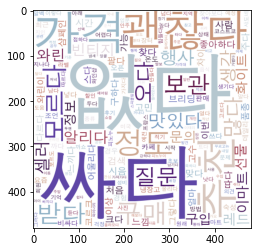

In [125]:
from wordcloud import WordCloud
from konlpy.tag import Twitter
from collections import Counter
import seaborn as sns

WORDS=[aa for a in QA.NOUNS for aa in a]

# 가장 많이 나온 단어부터 저장한다.
counts = Counter(WORDS)
tags = counts.most_common(700) 
lightwordcloud = WordCloud(background_color='white', 
                      width=480, height=480, 
                      font_path ="AppleGothic",
                      colormap = 'twilight_r').generate_from_frequencies(dict(tags))

plt.imshow(lightwordcloud)
lightwordcloud.to_file('WordCloud.jpg')

# 1


# 2

In [106]:
def get_text_with_word(word):
    l=re.findall('(ㅠㅠ)',word)
    L=re.findall('(ㅜㅜ)',word)
    i=re.findall('(\?\?)',word)
    return len(l)+len(i)+len(L)

In [107]:
QA['pain']=QA.contents.apply(lambda x :'pain' if get_text_with_word(x) != 0 else '')

In [108]:
PAIN=QA[QA.pain!='']

In [109]:
DOCLEN=QA[QA.doc_len>165] #2720

In [ ]:
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
    
def plot_2d_graph(vocabs, xs, ys):
    plt.figure(figsize=(20 ,20))
    font_name = font_manager.FontProperties(fname='c:\\windows\\fonts\\nanumbarungothic-yethangul.ttf',
                                           ).get_name()
    rc('font', family=font_name)
    rc('font', size=15)
    plt.scatter(xs, ys, marker = 'o')
    for i, v in enumerate(vocabs):
        plt.annotate(v, xy=(xs[i], ys[i]))

def Token2vec(DF,mincount):
    model = Word2Vec(sentences = DF.NOUNS, min_count = mincount, workers = 6, sg = 0)
    word_vectors = model.wv
    pca = PCA(n_components=5)
    vocabs = list(model.wv.index_to_key)
    word_vocab_list = [model.wv[v] for v in vocabs]
    xys = pca.fit_transform(word_vocab_list)
    xs = xys[:,0]
    ys = xys[:,1]
    plot_2d_graph(vocabs, xs, ys)

In [ ]:
#Token2vec(QA,10)

In [ ]:
def drop_certain_words(corpus, sparse_matrix, drop_words):
    drop_words_index = [np.where(corpus == word)[0][0] for word in drop_words]
    to_keep = sorted(set(range(sparse_matrix.shape[1])) - set(drop_words_index))
    corpus = corpus[to_keep]
    sparse_matrix = sparse_matrix[:, to_keep]
    return corpus, sparse_matrix

In [110]:
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

def TFIDF(DF):
    tfidv = TfidfVectorizer(min_df=0.01).fit(DF.corpus)
    #tfidf = TfidfVectorizer(max_features = 100, max_df=0.95, min_df=0).fit_transform(DF.corpus)# 상위 100개
    TFIDF=tfidv.transform(DF.corpus)
    #data_array = TFIDF.toarray()
    #text=tfidv.get_feature_names()
    return tfidv,TFIDF

In [113]:

from sklearn.decomposition import LatentDirichletAllocation
#tfidv,tfidf=TFIDF(QA)
tfidv,tfidf=TFIDF(QA)
lda=LatentDirichletAllocation(n_components=3)
lda.fit(tfidf)

def display_topics(model, feature_names, no_top_words):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        important_words = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
        print( f"Topic {topic_idx}")
        print(",".join(important_words))
        topics.append(important_words)
    return topics

In [114]:
topic=display_topics(lda,tfidv.get_feature_names(),20)

['괜찮다', '가격', '추천', '먹다', '이마트', '화이트', '어울리다', '레드', '팔다', '고민', '오다', '장터', '없다', '냉장고', '맛있다', '종류', '좋아하다', '스다', '낫다', '넣다']
Topic 0
괜찮다,가격,추천,먹다,이마트,화이트,어울리다,레드,팔다,고민,오다,장터,없다,냉장고,맛있다,종류,좋아하다,스다,낫다,넣다
['빈티지', '브리딩', '정도', '시음', '먹다', '시간', '샴페인', '느끼다', '질문', '차이', '셀러', '다르다', '숙성', '보관', '맛있다', '오픈', '그렇다', '없다', '크다', '적기']
Topic 1
빈티지,브리딩,정도,시음,먹다,시간,샴페인,느끼다,질문,차이,셀러,다르다,숙성,보관,맛있다,오픈,그렇다,없다,크다,적기
['받다', '싸다', '없다', '선물', '행사', '정보', '가격', '모르다', '구매', '검색', '코르크', '구입', '괜찮다', '사람', '구하다', '알리다', '와린', '많다', '추천', '오다']
Topic 2
받다,싸다,없다,선물,행사,정보,가격,모르다,구매,검색,코르크,구입,괜찮다,사람,구하다,알리다,와린,많다,추천,오다


In [ ]:
def closer_look(df, topic_num, content, limit=40):
    each_topic_df = df[df['topic label'] == topic_num]
    print(each_topic_df[['topic prob', '제목', '본문', '댓글']].sort_values(by='topic prob', ascending=False)[content][:limit])

In [119]:
lda.n_iter_

10

In [ ]:
import pyLDAvis.gensim_models
from gensim import corpora
import gensim

# gensim

In [ ]:
Token=QA.NOUNS
dictionary = corpora.Dictionary(Token)
corpus = [dictionary.doc2bow(text) for text in Token]

NUM_TOPICS = 10 #20개의 토픽, k=20
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=30)
topics = ldamodel.print_topics(num_words=4)

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(ldamodel, corpus, dictionary)
#vis = pyLDAvis.gensim_models.prepare(lda,QA.corpus,tfidv.get_feature_names())
pyLDAvis.display(vis)

In [ ]:
from apyori import apriori
re=list(apriori(QA.NOUNS,min_support=0.01))
df=pd.DataFrame(re)
df['length']=df['items'].apply(lambda x: len(x))
df=df[(df.length ==2) & (df.support >= 0.01)].sort_values('support',ascending=False) 

In [ ]:
import networkx as nx
G=nx.Graph()
ar=list(df['items'][:50])
G.add_edges_from(ar)

pr=nx.pagerank(G)
nsize=np.array([v for v in pr.values()])
nsize=2000*(nsize-min(nsize))/(max(nsize)-min(nsize))

pos=nx.circular_layout('G')

In [ ]:
plt.figure(figsize=(16,12))
plt.axis('off')

nx.draw_networkx(G,font_family='AppleGothic',font_size=15,
                 cmap=plt.cm.rainbow,node_size=nsize)
plt.savefig('SNA.png')